In [5]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, Dense, GRU, Activation, LSTM, Bidirectional, MultiHeadAttention, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers.legacy import Adam, RMSprop
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers.schedules import CosineDecay
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import os
import re
#from gensim.models import Word2Vec
import plotly.express as px
import keras.backend as K
from keras.regularizers import l2
from keras.callbacks import EarlyStopping


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yassineseidou/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yassineseidou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yassineseidou/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
# Lire le fichier texte et ajouter toutes les lignes dans une liste
with open("fleurs_mal.txt", 'r' , encoding = 'utf8') as f:
    lines = f.readlines()

df = ''.join(lines)

tokens = word_tokenize(df.lower())
print("There are :",len(tokens), "words in the document")
print("There are :",len(set(tokens)), "unique words in the document")

There are : 32562 words in the document
There are : 6975 unique words in the document


In [7]:
for idx, line in enumerate(lines):
    if "Charles Baudelaire avait un ami" in line:
        first_line = idx
    if "End of the Project Gutenberg EBook of Les Fleurs du Mal, by Charles Baudelaire" in line:
        last_line = idx

## Analyse Exploratoire

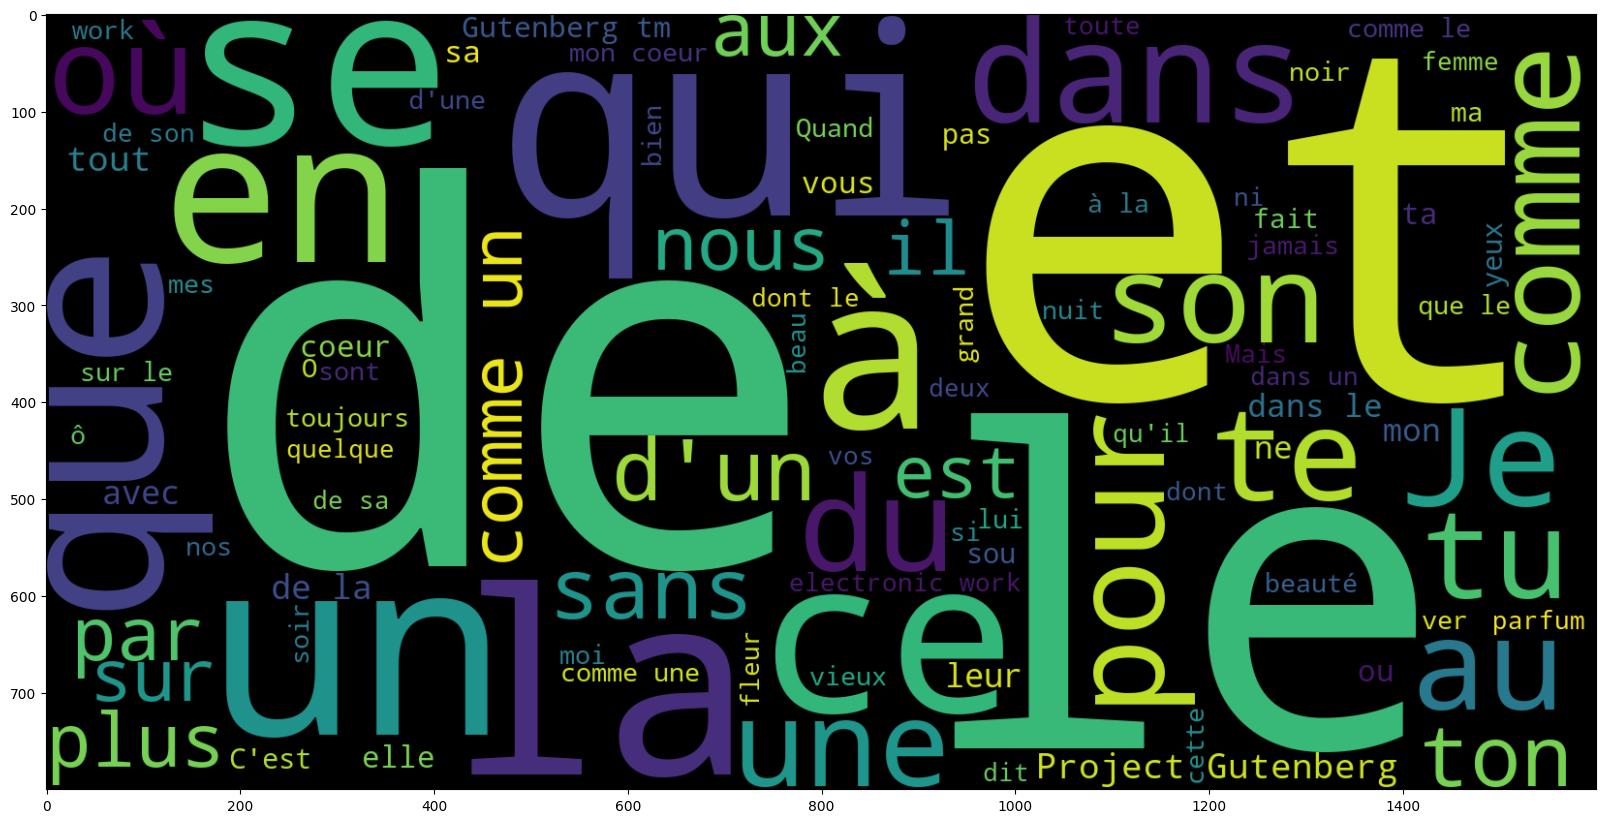

In [8]:
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=100,
               height=800,
               width=1600,
               ).generate(df)
plt.imshow(wc, interpolation="bilinear")

# visualize the distribution of number of words in a text

fig = px.histogram(x = [len(x) for x in tokens], nbins = 100)
fig.show()

In [9]:
stop_words = stopwords.words('french')
#stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'le', 'la', 'du', 'des', 'un', 'une', 'a'])
stop_words

['au',
 'aux',
 'avec',
 'ce',
 'ces',
 'dans',
 'de',
 'des',
 'du',
 'elle',
 'en',
 'et',
 'eux',
 'il',
 'ils',
 'je',
 'la',
 'le',
 'les',
 'leur',
 'lui',
 'ma',
 'mais',
 'me',
 'même',
 'mes',
 'moi',
 'mon',
 'ne',
 'nos',
 'notre',
 'nous',
 'on',
 'ou',
 'par',
 'pas',
 'pour',
 'qu',
 'que',
 'qui',
 'sa',
 'se',
 'ses',
 'son',
 'sur',
 'ta',
 'te',
 'tes',
 'toi',
 'ton',
 'tu',
 'un',
 'une',
 'vos',
 'votre',
 'vous',
 'c',
 'd',
 'j',
 'l',
 'à',
 'm',
 'n',
 's',
 't',
 'y',
 'été',
 'étée',
 'étées',
 'étés',
 'étant',
 'étante',
 'étants',
 'étantes',
 'suis',
 'es',
 'est',
 'sommes',
 'êtes',
 'sont',
 'serai',
 'seras',
 'sera',
 'serons',
 'serez',
 'seront',
 'serais',
 'serait',
 'serions',
 'seriez',
 'seraient',
 'étais',
 'était',
 'étions',
 'étiez',
 'étaient',
 'fus',
 'fut',
 'fûmes',
 'fûtes',
 'furent',
 'sois',
 'soit',
 'soyons',
 'soyez',
 'soient',
 'fusse',
 'fusses',
 'fût',
 'fussions',
 'fussiez',
 'fussent',
 'ayant',
 'ayante',
 'ayantes',


In [10]:
len(stop_words)

157

## Traitement du texte

In [11]:
# Initialisation du lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess_text(text, stop_words):
    """
    Nettoie et prétraite le texte :
    - Met en minuscule
    - Supprime les caractères spéciaux
    - Tokenize
    - Retire les stopwords
    - Lematise les mots restants
    """
    # Convertir en minuscule
    text = text.lower()
    
    # Supprimer les caractères spéciaux (on garde les mots uniquement)
    text = re.sub(r"[^\w\s]", "", text)
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Retirer les stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatisation
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return lemmatized_tokens

In [12]:
# Appliquer la fonction au corpus
preprocessed_tokens = preprocess_text(df, stop_words)

# Vérifier les résultats
print("Exemple de tokens prétraités :", preprocessed_tokens[:50])
print("Nombre total de mots après prétraitement :", len(preprocessed_tokens))
print("Nombre de mots uniques après prétraitement :", len(set(preprocessed_tokens)))


Exemple de tokens prétraités : ['the', 'project', 'gutenberg', 'ebook', 'of', 'fleurs', 'mal', 'by', 'charles', 'baudelaire', 'this', 'ebook', 'is', 'for', 'the', 'use', 'of', 'anyone', 'anywhere', 'at', 'no', 'cost', 'and', 'with', 'almost', 'no', 'restriction', 'whatsoever', 'you', 'may', 'copy', 'it', 'give', 'it', 'away', 'or', 'reuse', 'it', 'under', 'the', 'term', 'of', 'the', 'project', 'gutenberg', 'license', 'included', 'with', 'this', 'ebook']
Nombre total de mots après prétraitement : 18235
Nombre de mots uniques après prétraitement : 6654


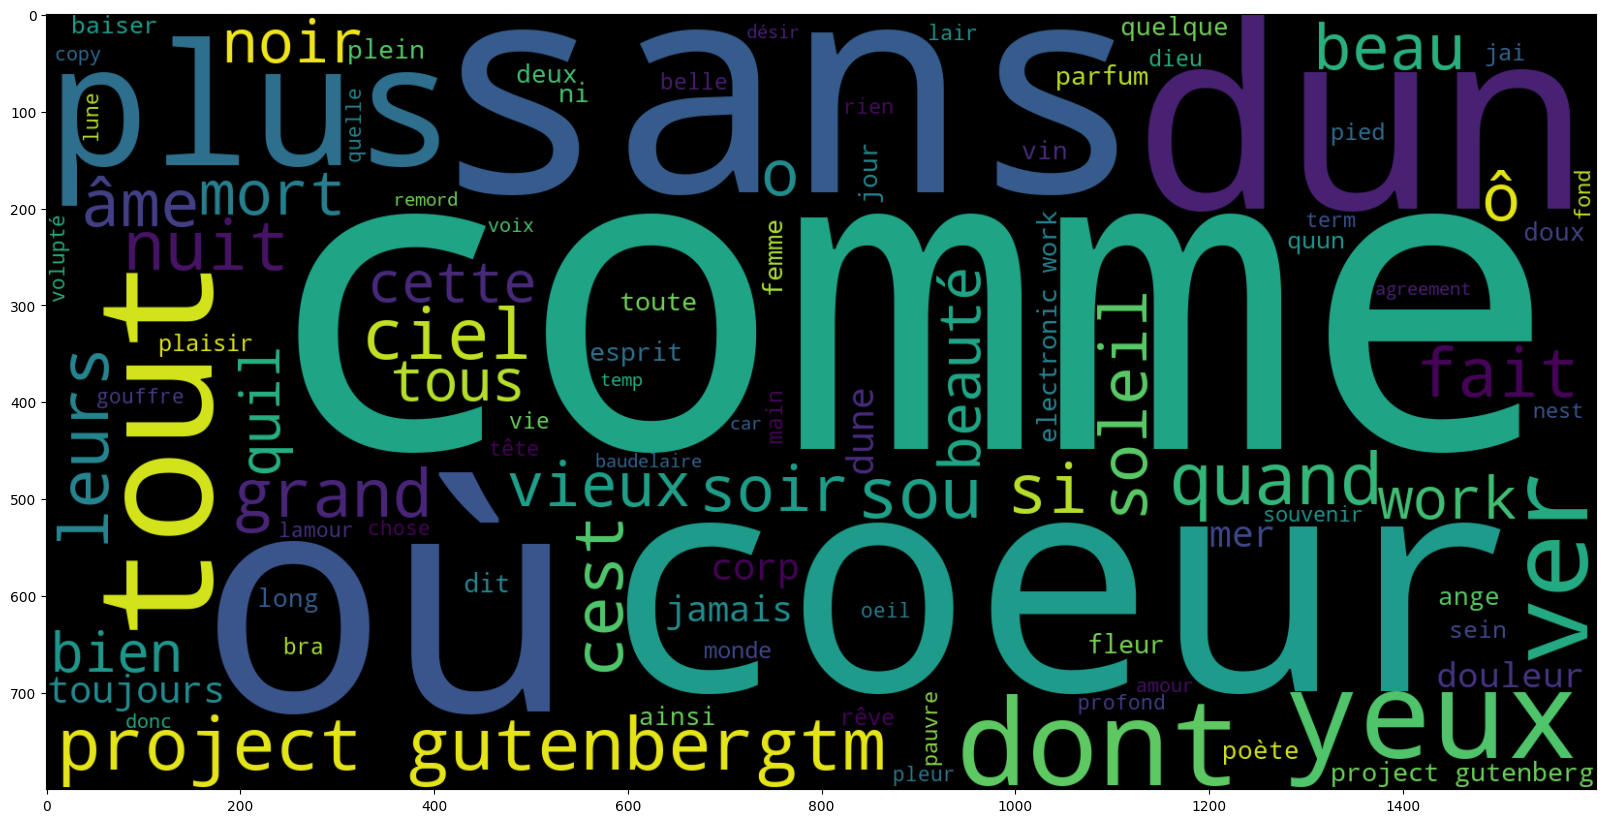

In [13]:
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=100,
               height=800,
               width=1600,
               ).generate(" ".join(preprocessed_tokens))
plt.imshow(wc, interpolation="bilinear")

# Distribution de la longueur des textes après prétraitement
fig = px.histogram(x=[len(x) for x in preprocessed_tokens], nbins=100)
fig.show()

In [14]:
for idx, line in enumerate(preprocessed_tokens):
    if "Charles Baudelaire" in line:
        first_line = idx
    if "End of the Project" in line:
        last_line = idx

In [15]:
lines = preprocessed_tokens[first_line:last_line]
lines = [l.lower().strip().replace('_', '') for l in lines if len(l) > 1]
text = " ".join(lines)

In [16]:
characters = sorted(set(text))
n_characters = len(characters)

In [17]:
# SEQLEN représente la taille de la séquence de lettres à passer en entrée
SEQLEN = 10
step = 1
input_characters, labels = [], []
# On parcourt le corpus de texte avec une fenêtre glissante
for i in range(0, len(text) - SEQLEN, step):
    input_characters.append(text[i:i + SEQLEN])
    labels.append(text[i + SEQLEN])

print(f"Il y a {len(input_characters)} séquences de {SEQLEN} caractères dans le corpus d'entraînement.")

Il y a 34848 séquences de 10 caractères dans le corpus d'entraînement.


In [18]:
# Encodage caractère -> indice du dictionaire
char2index = dict((c, i) for i, c in enumerate(characters))
# Encodage de l'indice vers le caractère (utilisé pour décoder les prédictions du modèle)
index2char = dict((i, c) for i, c in enumerate(characters)) # mapping index -> char in dictionary

In [19]:


# Initialisation des tenseurs
X = np.zeros((len(input_characters), SEQLEN, n_characters), dtype=bool)
y = np.zeros((len(input_characters), n_characters), dtype=bool)

# Remplissage des tenseurs X et y
for idx_seq, sequence in enumerate(input_characters):
    for idx_char, char in enumerate(sequence):
        # Encode chaque caractère dans une représentation one-hot
        X[idx_seq, idx_char, char2index[char]] = 1
    # Encode le caractère cible correspondant
    y[idx_seq, char2index[labels[idx_seq]]] = 1

print("Encodage terminé.")
print(f"X shape: {X.shape}, y shape: {y.shape}")

Encodage terminé.
X shape: (34848, 10, 47), y shape: (34848, 47)


In [20]:
from sklearn.model_selection import train_test_split

# 80% des données en apprentissage, 20% en validation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42)

### Model

In [21]:
from tensorflow.keras.callbacks import Callback

# Cosine Annealing Scheduler
class CosineAnnealingScheduler(Callback):
    def __init__(self, max_lr, min_lr, total_epochs):
        super(CosineAnnealingScheduler, self).__init__()
        self.max_lr = max_lr
        self.min_lr = min_lr
        self.total_epochs = total_epochs

    def on_epoch_begin(self, epoch, logs=None):
        # Calculer le learning rate pour l'epoch courant
        cosine_lr = self.min_lr + 0.3 * (self.max_lr - self.min_lr) * (
            1 + np.cos(np.pi * epoch / self.total_epochs)
        )
        # Mettre à jour le learning rate de l'optimiseur
        self.model.optimizer.lr.assign(cosine_lr)
        print(f"Epoch {epoch+1}: Learning rate is {cosine_lr:.6f}")

In [30]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.regularizers import l2

class LinearRecurrentUnit(layers.Layer):
    def __init__(self, input_size, hidden_size, output_size, kernel_regularizer=None):
        super(LinearRecurrentUnit, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.kernel_regularizer = kernel_regularizer
        
        # Define the linear recurrence matrices (A, B, C, D)
        self.A = self.add_weight(
            "A", 
            shape=(hidden_size, hidden_size),
            initializer="random_normal",
            regularizer=kernel_regularizer,
            trainable=True
        )
        self.B = self.add_weight(
            "B", 
            shape=(input_size, hidden_size),
            initializer="random_normal",
            regularizer=kernel_regularizer,
            trainable=True
        )
        self.C = self.add_weight(
            "C", 
            shape=(hidden_size, output_size),
            initializer="random_normal",
            regularizer=kernel_regularizer,
            trainable=True
        )
        self.D = self.add_weight(
            "D", 
            shape=(input_size, output_size),
            initializer="random_normal",
            regularizer=kernel_regularizer,
            trainable=True
        )
        
        # Layer normalization
        self.norm = layers.LayerNormalization()

    def call(self, inputs, training=False):
        # Get the batch size dynamically from inputs
        batch_size = tf.shape(inputs)[0]
        seq_len = inputs.shape[1]
        
        # Initialize hidden state with zeros, using batch_size dynamically
        h = tf.zeros((batch_size, self.hidden_size), dtype=tf.float32)
        outputs = []
        
        for t in range(seq_len):
            u = inputs[:, t, :]
            h = tf.matmul(h, self.A) + tf.matmul(u, self.B)
            h = self.norm(h)
            # Compute output at each time step
            y_t = tf.matmul(h, self.C) + tf.matmul(u, self.D)
            outputs.append(y_t)
        
        # Stack outputs to form a sequence
        return tf.stack(outputs, axis=1)

# Model parameters
h_size = 128
dropout_rate = 0.1
n_characters = 47
output_size = 47  # Should match your target dimension
SEQLEN = 10
num_epochs = 100
batch_size = 64
weight_decay = 0.0001

# Learning rate setup
initial_learning_rate = 0.001
decay_steps = num_epochs * (1000 // batch_size)
cosine_decay = CosineDecay(initial_learning_rate, decay_steps)

# Optimizer
optim = Adam(initial_learning_rate)

# Build the model
model = Sequential()
model.add(LinearRecurrentUnit(
    input_size=n_characters,
    hidden_size=h_size,
    output_size=h_size,
    kernel_regularizer=l2(weight_decay)
))
BatchNormalization()

model.add(LinearRecurrentUnit(
    input_size=h_size,
    hidden_size=h_size,
    output_size=h_size,
    kernel_regularizer=l2(weight_decay)
))
BatchNormalization()

model.add(LinearRecurrentUnit(
    input_size=h_size,
    hidden_size=h_size,
    output_size=h_size,
    kernel_regularizer=l2(weight_decay)
))
BatchNormalization()

model.add(LinearRecurrentUnit(
    input_size=h_size,
    hidden_size=h_size,
    output_size=h_size,
    kernel_regularizer=l2(weight_decay)
))
BatchNormalization()

model.add(layers.Dropout(dropout_rate))

# Take the last time step's output for classification
model.add(layers.Lambda(lambda x: x[:, -1, :]))
model.add(layers.Dense(n_characters))
model.add(layers.Activation("softmax"))

# Compile the model
model.compile(
    loss="categorical_crossentropy",
    optimizer=optim,
    metrics=['accuracy']
)

# Set input shape for the model (batch_size, seq_len, input_size)
model.build(input_shape=(None, SEQLEN, n_characters))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 linear_recurrent_unit_17 (  (None, 10, 128)           45056     
 LinearRecurrentUnit)                                            
                                                                 
 linear_recurrent_unit_18 (  (None, 10, 128)           65792     
 LinearRecurrentUnit)                                            
                                                                 
 linear_recurrent_unit_19 (  (None, 10, 128)           65792     
 LinearRecurrentUnit)                                            
                                                                 
 linear_recurrent_unit_20 (  (None, 10, 128)           65792     
 LinearRecurrentUnit)                                            
                                                                 
 dropout_3 (Dropout)         (None, 10, 128)          

Epoch 1: Learning rate is 0.000640
Epoch 1/100
491/491 [==============================] - 25s 42ms/step - loss: 2.8375 - accuracy: 0.1916 - val_loss: 2.6025 - val_accuracy: 0.2433
Epoch 2: Learning rate is 0.000640
Epoch 2/100
491/491 [==============================] - 22s 45ms/step - loss: 2.4943 - accuracy: 0.2672 - val_loss: 2.4645 - val_accuracy: 0.2746
Epoch 3: Learning rate is 0.000639
Epoch 3/100
491/491 [==============================] - 21s 44ms/step - loss: 2.4051 - accuracy: 0.2881 - val_loss: 2.4491 - val_accuracy: 0.2872
Epoch 4: Learning rate is 0.000639
Epoch 4/100
491/491 [==============================] - 23s 47ms/step - loss: 2.3591 - accuracy: 0.2939 - val_loss: 2.3530 - val_accuracy: 0.3010
Epoch 5: Learning rate is 0.000638
Epoch 5/100
491/491 [==============================] - 20s 42ms/step - loss: 2.3303 - accuracy: 0.3022 - val_loss: 2.3508 - val_accuracy: 0.2924
Epoch 6: Learning rate is 0.000637
Epoch 6/100
491/491 [==============================] - 21s 42ms/s

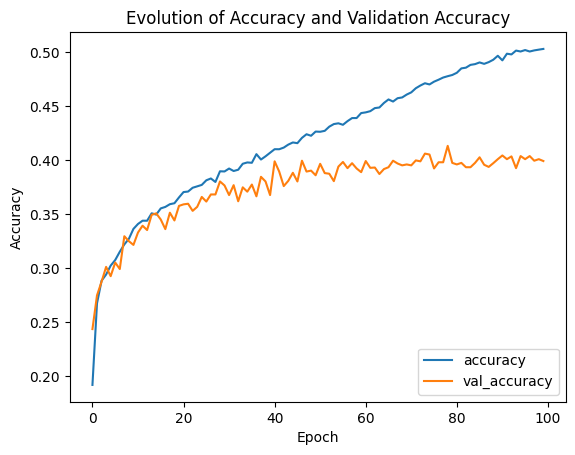

In [31]:


#model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs)
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import entropy

cosine_scheduler = CosineAnnealingScheduler(max_lr=0.001, min_lr=0.0001, total_epochs=num_epochs)
# Définition de l'EarlyStopping pour arrêter l'entraînement en cas de surapprentissage
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Visualisation de l'évolution de l'accuracy et de la val_accuracy
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[cosine_scheduler])

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Evolution of Accuracy and Validation Accuracy')
plt.show()

Layer: linear_recurrent_unit_17
A shape: (128, 128)


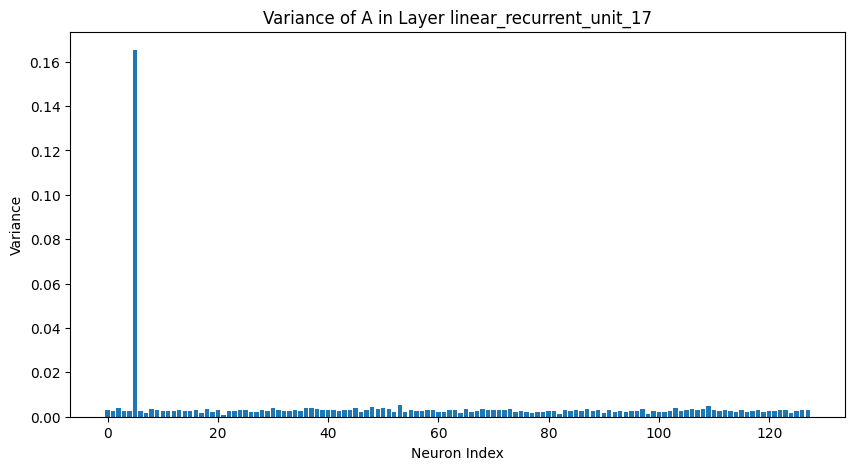

B shape: (47, 128)


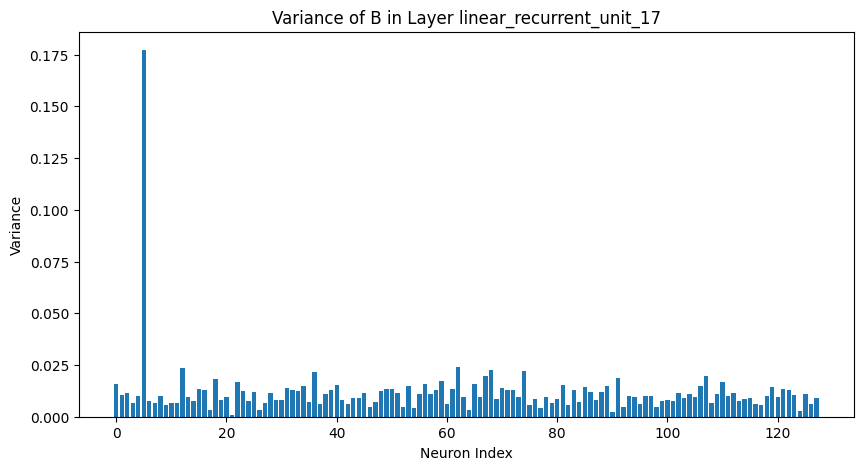

C shape: (128, 128)


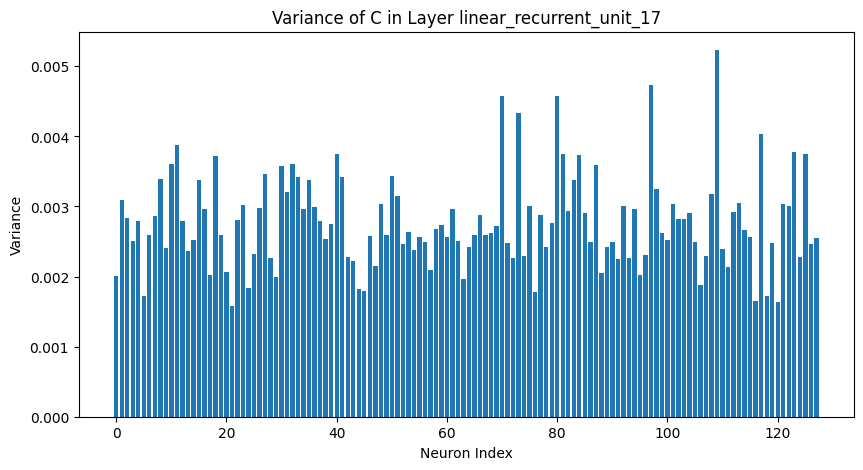

D shape: (47, 128)


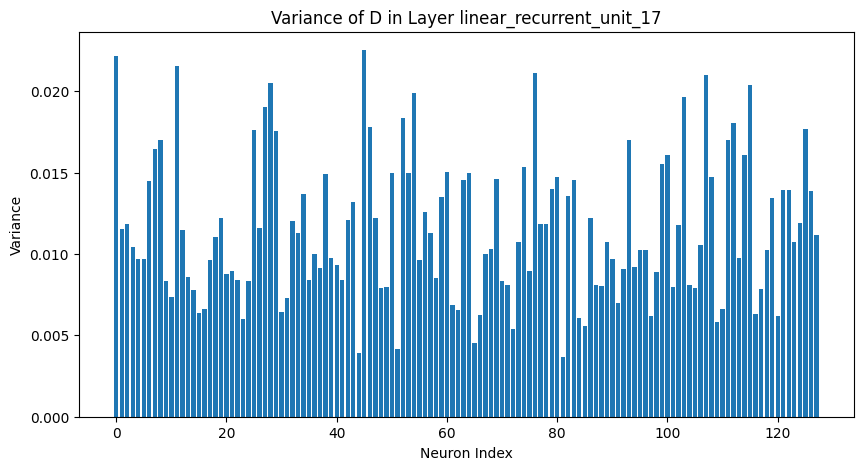

Layer: linear_recurrent_unit_18
A shape: (128, 128)


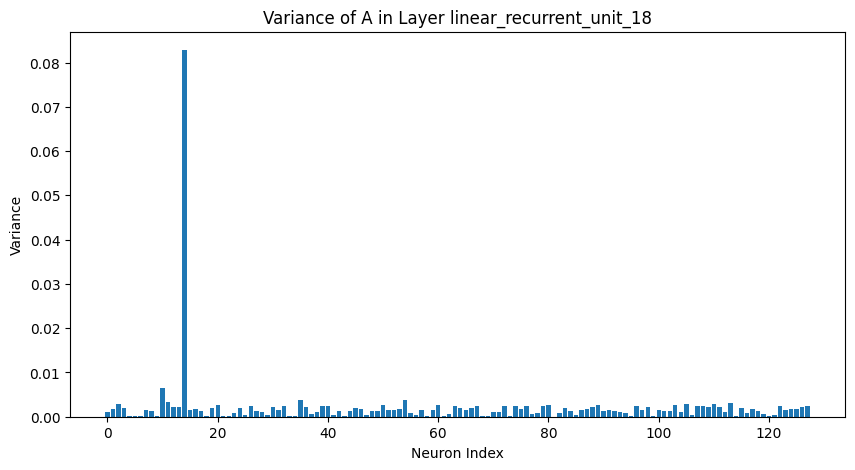

B shape: (128, 128)


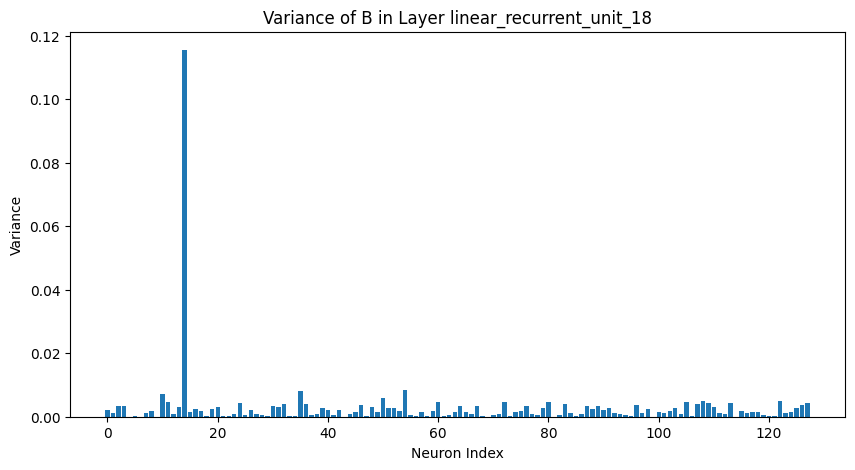

C shape: (128, 128)


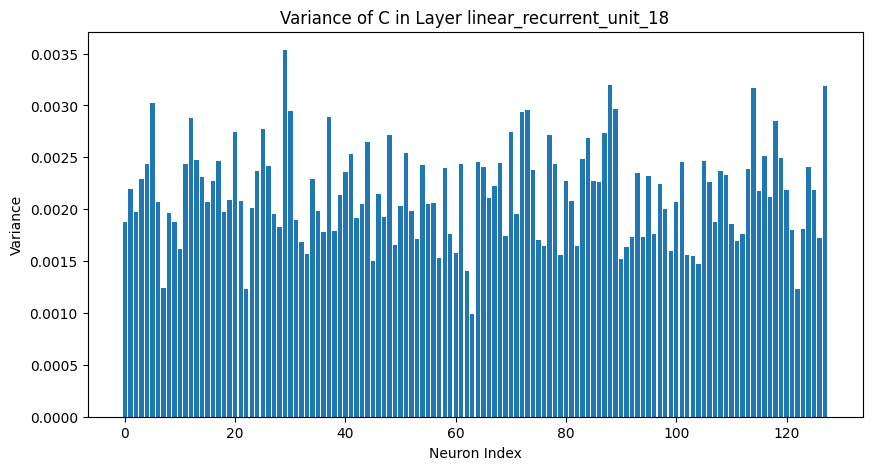

D shape: (128, 128)


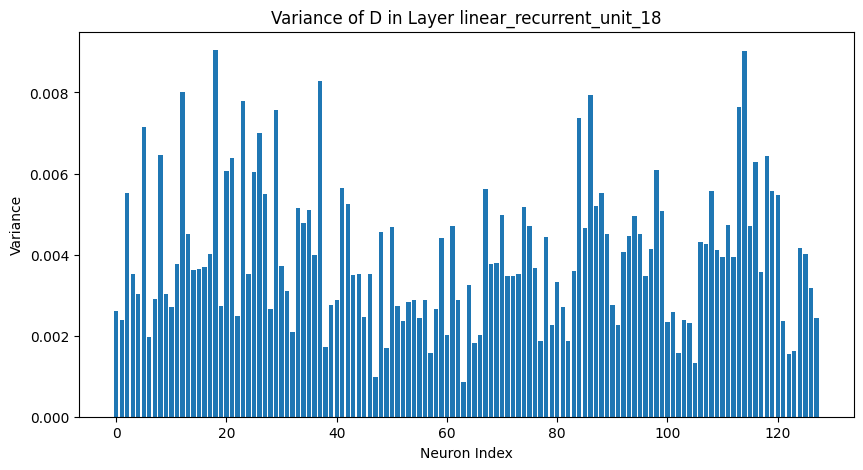

Layer: linear_recurrent_unit_19
A shape: (128, 128)


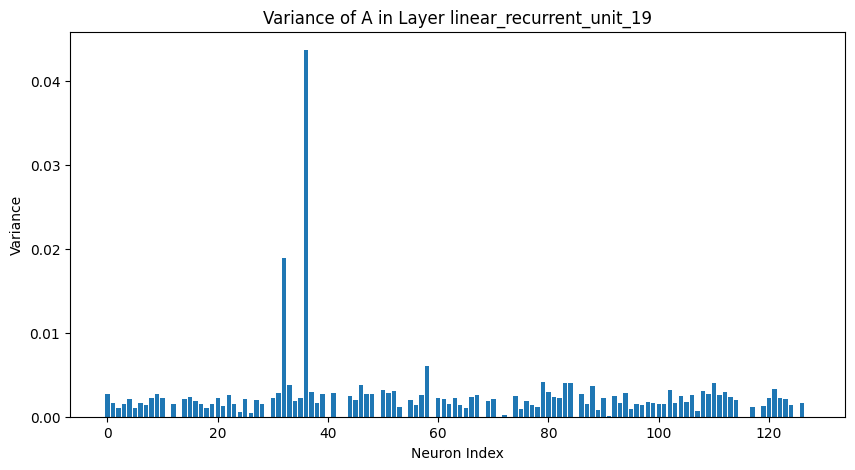

B shape: (128, 128)


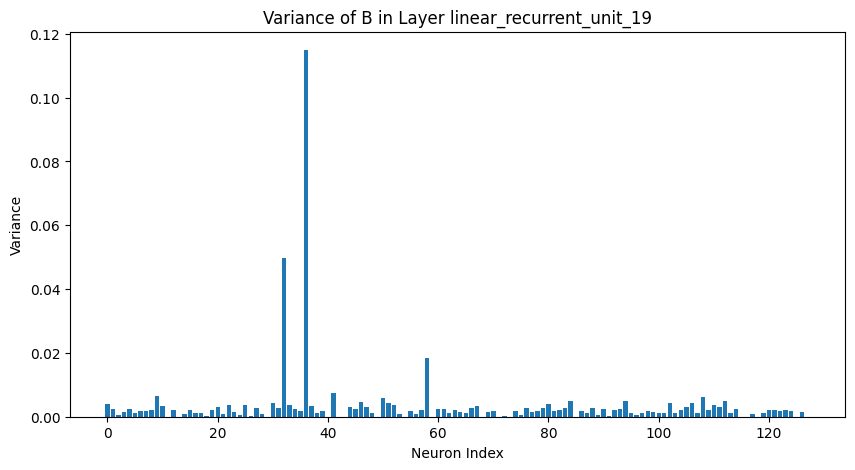

C shape: (128, 128)


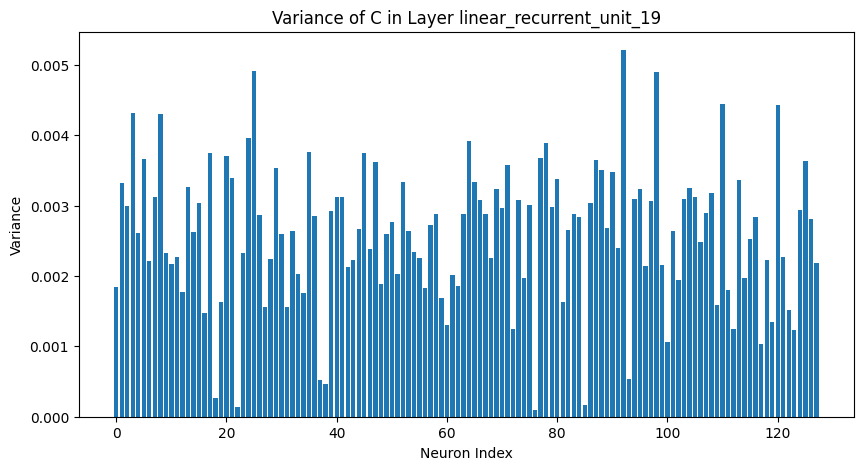

D shape: (128, 128)


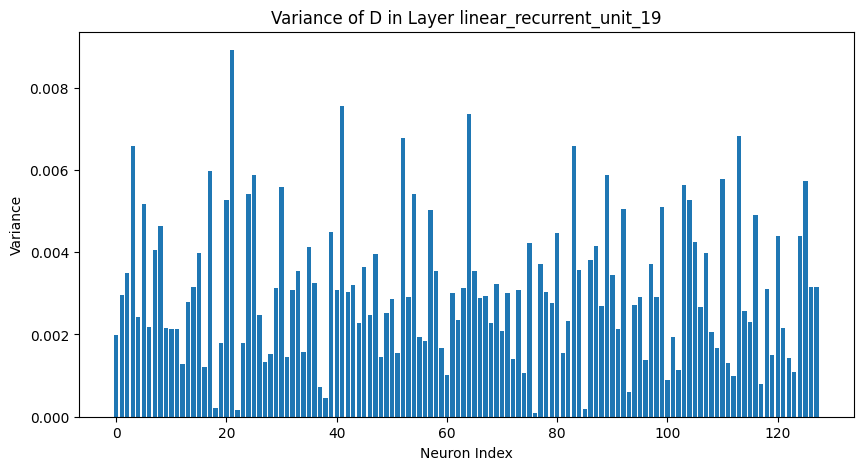

Layer: linear_recurrent_unit_20
A shape: (128, 128)


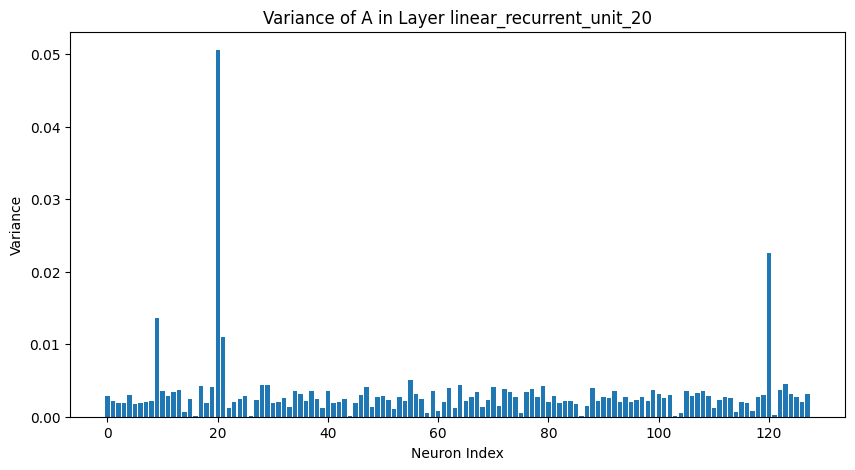

B shape: (128, 128)


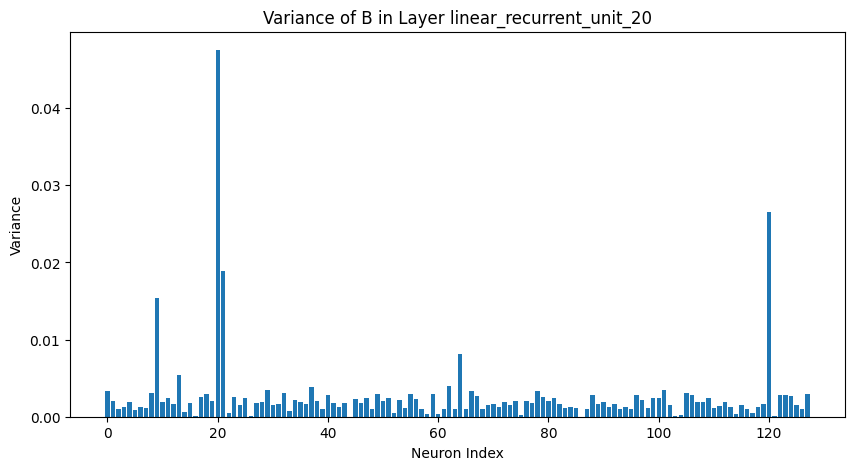

C shape: (128, 128)


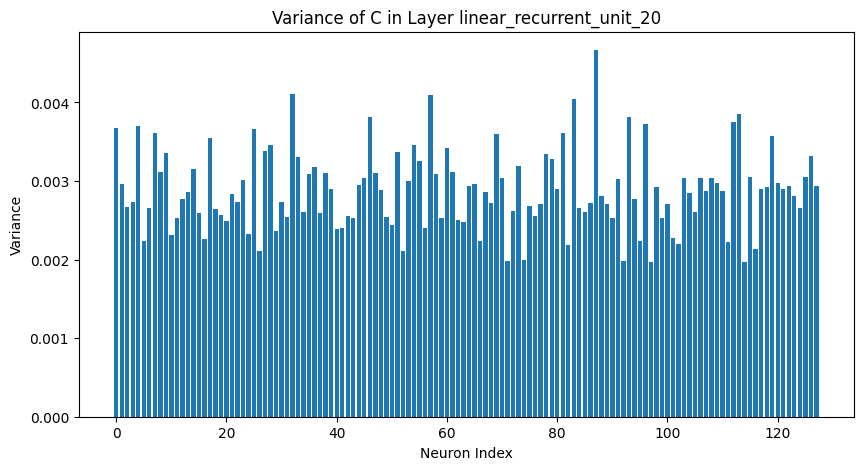

D shape: (128, 128)


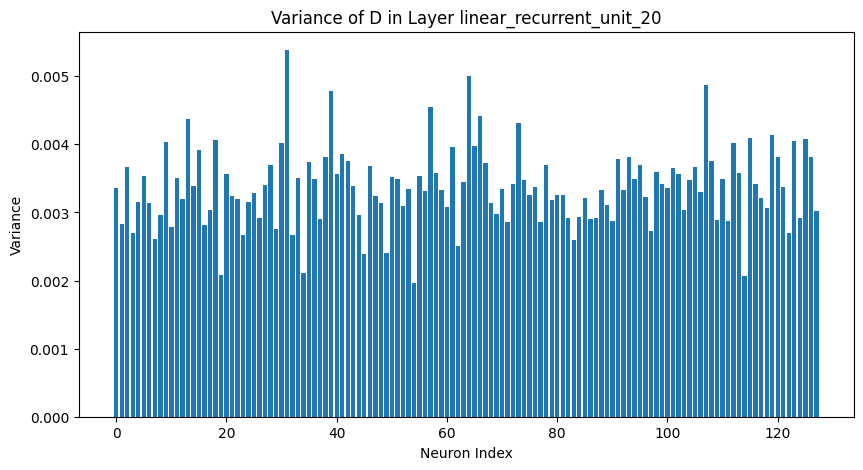

Layer lambda_3 is not a LinearRecurrentUnit, Dense, or Dropout layer.
Layer: dense_3
Weights shape: (128, 47), Biases shape: (47,)


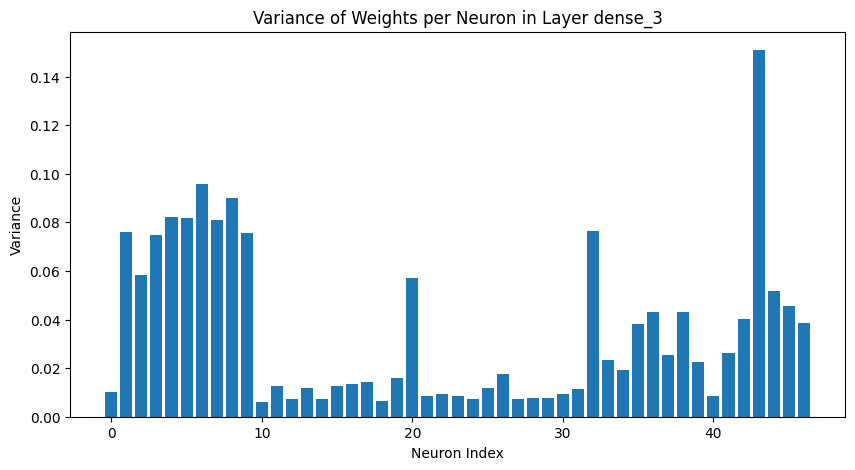

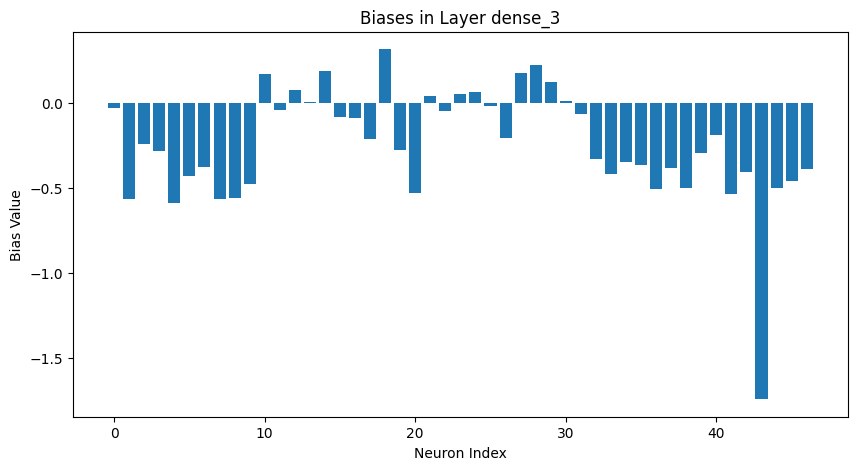

Layer activation_3 is not a LinearRecurrentUnit, Dense, or Dropout layer.


In [32]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras import layers

def plot_layer_parameters(model):
    for layer in model.layers:
        if isinstance(layer, (Dense, Dropout)):
            # Handle Dense and Dropout layers
            if isinstance(layer, Dense):
                layer_weights = layer.get_weights()
                if len(layer_weights) >= 2:
                    weights = layer_weights[0]
                    biases = layer_weights[1]
                    print(f"Layer: {layer.name}")
                    print(f"Weights shape: {weights.shape}, Biases shape: {biases.shape}")
                    weight_variances = np.var(weights, axis=0)

                    plt.figure(figsize=(10, 5))
                    plt.bar(range(len(weight_variances)), weight_variances)
                    plt.title(f'Variance of Weights per Neuron in Layer {layer.name}')
                    plt.xlabel('Neuron Index')
                    plt.ylabel('Variance')
                    plt.show()

                    if len(biases.shape) == 1:
                        plt.figure(figsize=(10, 5))
                        plt.bar(range(len(biases)), biases)
                        plt.title(f'Biases in Layer {layer.name}')
                        plt.xlabel('Neuron Index')
                        plt.ylabel('Bias Value')
                        plt.show()
                else:
                    print(f"Layer {layer.name} does not have standard weights and biases.")
        
        elif isinstance(layer, LinearRecurrentUnit):
            # Handle LinearRecurrentUnit layer
            layer_weights = [
                layer.A.numpy(), layer.B.numpy(), layer.C.numpy(), layer.D.numpy()
            ]
            
            print(f"Layer: {layer.name}")
            for i, param in enumerate(layer_weights):
                param_name = ['A', 'B', 'C', 'D'][i]
                print(f"{param_name} shape: {param.shape}")
                
                # Plot the variance of each parameter
                weight_variances = np.var(param, axis=0)
                
                plt.figure(figsize=(10, 5))
                plt.bar(range(len(weight_variances)), weight_variances)
                plt.title(f'Variance of {param_name} in Layer {layer.name}')
                plt.xlabel('Neuron Index')
                plt.ylabel('Variance')
                plt.show()
        
        else:
            print(f"Layer {layer.name} is not a LinearRecurrentUnit, Dense, or Dropout layer.")

# Call the function with your model
plot_layer_parameters(model)


In [33]:
scores_train = model.evaluate(X_train, y_train, verbose=1)
scores_test = model.evaluate(X_test, y_test, verbose=1)
print(f"Performances (apprentissage, {model.metrics_names[1]}) = {scores_train[1]*100:.2f}")
print(f"Performances (validation, {model.metrics_names[1]}) = {scores_test[1]*100:.2f}")


109/109 [==============================] - 1s 9ms/step - loss: 2.1247 - accuracy: 0.3991
Performances (apprentissage, accuracy) = 52.32
Performances (validation, accuracy) = 39.91


In [ ]:
#model_name = f"SimpleRNN_{h_size}_{num_epochs}epochs"
#model.save(model_name)

In [ ]:
#from tensorflow.keras.models import load_model
#model = load_model(model_name)
#model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
#model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, 10, 128)           72576     
                                                                 
 gru_6 (GRU)                 (None, 128)               99072     
                                                                 
 dense_1 (Dense)             (None, 59)                7611      
                                                                 
 activation_1 (Activation)   (None, 59)                0         
                                                                 
Total params: 179259 (700.23 KB)
Trainable params: 179259 (700.23 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
idx = 10
# index2char permet de repasser de l'encodage one-hot au caractère du dictionnaire
initial_characters = [index2char[np.argmax(c)] for c in X_train[idx]]
initial_text = "".join(initial_characters)
print(f"La séquence n°{idx} est : '{initial_text}'")

La séquence n°10 est : 't faire ép'


In [35]:
test_sequence = np.zeros((1, SEQLEN, n_characters), dtype=bool)
test_sequence[0] = X_train[idx]
prediction = model.predict(test_sequence)
print(prediction)

1/1 [==============================] - 2s 2s/step
[[1.8248733e-02 4.2059270e-07 7.3798467e-10 6.4718555e-09 3.8619938e-09
  1.0577313e-09 1.6948849e-10 3.8313569e-08 1.0206200e-11 7.4901774e-09
  1.0005992e-01 5.5856910e-03 1.1780952e-04 2.0137802e-03 4.9452111e-02
  2.8933942e-05 2.0511565e-05 9.3378210e-03 5.9414748e-02 4.0317448e-07
  7.7861166e-09 3.5871366e-01 3.6897936e-03 1.9834398e-03 4.4138946e-02
  4.5312213e-04 1.2771611e-06 2.7891737e-01 2.7329824e-03 8.2096194e-05
  3.8917895e-02 3.8873433e-05 9.2307758e-08 1.2763051e-06 1.1352658e-04
  1.0604935e-04 9.7435359e-06 3.1955060e-04 1.8767923e-07 5.2812034e-03
  2.0171868e-02 2.2224065e-05 1.8814546e-06 6.4145710e-14 1.4300710e-05
  7.7045001e-08 7.4745758e-06]]


In [36]:
def sample(probabilities, temperature=1.0):
    probabilities = np.asarray(probabilities).astype('float64')
    # Modifie la distribution selon la valeur de la température
    probabilities = pow(probabilities, 1.0/temperature)
    probabilities /= np.sum(probabilities)
    # Tire des variables aléatoires selon la distribution multinomiale transformée
    random_values = np.random.multinomial(1, probabilities, 1)
    # Renvoie le symbole échantillonné
    return np.argmax(random_values)

In [37]:
# Longueur du texte à générer (en caractères)
text_length = 200
# Température
temperature = 0.5

generated_text = initial_text
network_input = test_sequence

for i in range(text_length):
    last_characters = generated_text[-SEQLEN:]
    
    # Préparer l'entrée pour la prédiction
    test_sequence = np.zeros((1, SEQLEN, n_characters), dtype=bool)
    for t, char in enumerate(last_characters):
        test_sequence[0, t, char2index[char]] = 1
    
    # Prédiction du modèle
    prediction = model.predict(test_sequence, verbose=0)
    
    # Échantillonner un caractère à partir de la distribution de probabilité
    predicted_char_index = sample(prediction[0], temperature)
    predicted_char = index2char[predicted_char_index]
    
    # Ajouter le caractère prédit au texte généré
    generated_text += predicted_char

print("Texte généré:")
print(generated_text)

Texte généré:
t faire éplus paroi sombre perve hore comme beauté nuit enferaient méterne aprésibre plute car implange vie persoi pois profond ples cour désir troute plint prendeur lenfreuse profond belle derrière ongerre étr


In [38]:


# Fonction de softmax
def softmax(logits):
    exp_logits = np.exp(logits - np.max(logits))  # Stabilité numérique
    return exp_logits / np.sum(exp_logits)

# Fonction de sampling avec température et top-k
def sample(preds, temperature=1.0, top_k=5):
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds + 1e-10) / temperature  # Appliquer température
    preds = softmax(preds)

    # Optionnel: Limiter aux k meilleures probabilités
    if top_k > 0:
        top_k_indices = np.argsort(preds)[-top_k:]
        preds_top_k = preds[top_k_indices]
        preds_top_k /= np.sum(preds_top_k)  # Renormaliser
        return np.random.choice(top_k_indices, p=preds_top_k)
    
    return np.random.choice(len(preds), p=preds)

# 3. Génération de texte avec self-probing et calcul de l'entropie
def generate_text_with_entropy(model, initial_text, text_length=200, temperature=0.7, num_samples=10, top_k=5):
    generated_texts = []
    entropies = []
    
    for _ in range(num_samples):
        generated_text = initial_text
        network_input = np.zeros((1, SEQLEN, n_characters), dtype=bool)
        for t, char in enumerate(initial_text):
            if char in char2index:
                network_input[0, t, char2index[char]] = 1
        
        for i in range(text_length):
            prediction = model.predict(network_input, verbose=0)[0]

            # Appliquer le sampling
            predicted_char_index = sample(prediction, temperature, top_k)
            predicted_char = index2char[predicted_char_index]
            
            # Ajouter le caractère prédit au texte généré
            generated_text += predicted_char
            
            # Mettre à jour l'entrée du réseau (Recréer plutôt que décaler)
            network_input = np.zeros((1, SEQLEN, n_characters), dtype=bool)
            last_chars = generated_text[-SEQLEN:]
            for t, char in enumerate(last_chars):
                if char in char2index:
                    network_input[0, t, char2index[char]] = 1
        
        generated_texts.append(generated_text)
        
        # Calcul de l'entropie sur la dernière sortie
        logits = model.predict(network_input, verbose=0)[0]
        probs = softmax(logits)  # Softmax appliqué correctement
        entropies.append(entropy(probs))
    
    return generated_texts, entropies

# Génération de texte avec self-probing et calcul de l'entropie
generated_texts, entropies = generate_text_with_entropy(model, initial_text, text_length=200, temperature=0.7, num_samples=10, top_k=5)

for i, (text, ent) in enumerate(zip(generated_texts, entropies)):
    print(f"Sample {i+1}:")
    print(text)
    print(f"Entropy: {ent:.4f}")
    print("-" * 80)

Sample 1:
t faire éplollive beaut sournus défore comme froides pluire siter longues sourint leurs paresse peut cour deux resterne cest profond car vers corpe connières presque cette désirait lang ressent comme flée comme
Entropy: 3.8320
--------------------------------------------------------------------------------
Sample 2:
t faire épare paressent déchose pleure paresse fierté plésir seule comme flemprés vins corsté semblait puis dence cerves bourbelait soirs vaspe comme nott douleur dun sange lair comme remère sombre fleurs pois 
Entropy: 3.8495
--------------------------------------------------------------------------------
Sample 3:
t faire éprend perai femme beauté dester sen charmant miron plit crimant coeur souverait longe main lingnie tout déposant saprès dantes sou pleure si parfume regarde cris profond deur quun vage prendre filo der
Entropy: 3.8388
--------------------------------------------------------------------------------
Sample 4:
t faire éplange pers désère solosass

In [39]:
entropies

[3.8319786,
 3.8494902,
 3.8387852,
 3.8302953,
 3.8446383,
 3.8422797,
 3.8463175,
 3.8340456,
 3.8496397,
 3.8496237]

In [40]:
import random

def introduce_typos(text, error_rate=0.1):
    """Ajoute des erreurs aléatoires dans un texte avec un certain taux de bruit."""
    chars = list(text)
    for i in range(len(chars)):
        if random.random() < error_rate:
            chars[i] = random.choice("abcdefghijklmnopqrstuvwxyz")  # Substitue une lettre
    return "".join(chars)



In [41]:
def correct_text(model, noisy_text, char2index, index2char, SEQLEN, n_characters, temperature=0.5):
    """ Corrige un texte bruité en générant une version corrigée avec le modèle """
    corrected_text = noisy_text[:SEQLEN]  # Conserver le début intact
    for i in range(len(noisy_text) - SEQLEN):
        last_characters = corrected_text[-SEQLEN:]

        # Préparer l'entrée pour la prédiction
        test_sequence = np.zeros((1, SEQLEN, n_characters), dtype=bool)
        for t, char in enumerate(last_characters):
            if char in char2index:
                test_sequence[0, t, char2index[char]] = 1

        # Prédiction du modèle
        prediction = model.predict(test_sequence, verbose=0)

        # Échantillonner un caractère à partir de la distribution de probabilité
        predicted_char_index = sample(prediction[0], temperature)
        predicted_char = index2char[predicted_char_index]

        # Ajouter le caractère prédit au texte corrigé
        corrected_text += predicted_char

    return corrected_text

In [42]:
# Exemple
original_text = "Bonjour, comment allez-vous aujourd'hui ?"
noisy_text = introduce_typos(original_text, error_rate=0.15)

corrected_text = correct_text(model, noisy_text, char2index, index2char, SEQLEN, n_characters)

print(f"Texte original : {original_text}")
print("Texte bruité   :", noisy_text)
print("Texte corrigé  :", corrected_text)

Texte original : Bonjour, comment allez-vous aujourd'hui ?
Texte bruité   : Bhnjour, comment allez-fous aujourd'hsi ?
Texte corrigé  : Bhnjour, comme fait cours pare dien renfi


In [43]:
import Levenshtein

def character_error_rate(reference, hypothesis):
    """Calcule le CER (Character Error Rate)"""
    return Levenshtein.distance(reference, hypothesis) / len(reference)

def word_error_rate(reference, hypothesis):
    """Calcule le WER (Word Error Rate)"""
    ref_words = reference.split()
    hyp_words = hypothesis.split()
    return Levenshtein.distance(" ".join(ref_words), " ".join(hyp_words)) / len(ref_words)

cer = character_error_rate(original_text, corrected_text)
wer = word_error_rate(original_text, corrected_text)

print(f"CER : {cer:.2%}")
print(f"WER : {wer:.2%}")

CER : 60.98%
WER : 500.00%
